## Setup

Included here are various tools for analyzing CHIRON spectra. This is currently set for Fiber mode but can quite easily be adopted to Slicer mode if needed. Someday I'll put in a clean toggle.

Anything with !!!!! should be altered for YOUR machine and data files etc. Default is you specify a cluster name and everything is handled from there.

In [1]:
#import Python stuff
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 32,'lines.linewidth':3})
import matplotlib.cm as cm
from os.path import exists
from astropy.io import fits
from PyAstronomy import pyasl
from astropy.time import Time
from PyAstronomy.pyaC import pyaErrors as PE
from PyAstronomy.pyasl import _ic
import glob
from lmfit import Model
from scipy.signal import argrelextrema
import math

#directories:
csdir='/Users/Cougy/Desktop/PublicChironTest/stds/' #!!!!! where you keep your CHIRON data for your standards. Put the reference data file CHIRON_standards_grand_summary.dat here.
ctdir='/Users/Cougy/Desktop/PublicChironTest/targs/' #!!!!! where you keep your CHIRON achi###.fits files and ###.log files of the targets you'd like to analyze
cluster='targs' #!!!!! which cluster you're measuring. Default is code measures everything in the folder.

#FILES: !!!!!
# Place standard .fits files, CHIRON_standards_grand_summary.dat, and blaze.dat into standards directory csdir.
# Place target .log files and .fits files into target directory ctdir.
# Place this Python code wherever.
# When it's time for fitvsini, place (cluster)_SpTGuess.dat in ctdir.

#Handy way to open data files:
def opendat0(dir,filename): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    labels=dat[0][0:-1].split()
    dat2=[[a.strip('\n') for a in d.split('\t')] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    dat,label=opendat0(dirr,filename)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    return varrs

def hmsdms(ra,dec): #input in degrees, output in HH MM S.SSS
    H=ra/15.
    h=int(H)
    M=(H-h)*60.
    m=int(M)
    s=(M-m)*60.
    
    DEC=abs(dec)
    sign=dec/DEC
    dd=int(DEC)
    d=int(sign*dd)
    AM=(DEC-dd)*60.
    am=int(AM)
    ass=(AM-am)*60.
    return str(h)+' '+str(m)+' '+str(round(s,3))+'\t'+str(d)+' '+str(am)+' '+str(round(ass,3))

def dmshms(ra,dec): #input HH:MM:SS.SSS or HH MM SS.SSS, output degrees
    if ':' in ra:
        splitchar=':'
    else:
        splitchar=r' '
    hms=[a.split(splitchar) for a in ra]
    h=[float(a[0])*15. for a in hms]
    m=[float(a[1])*15./60. for a in hms]
    s=[float(a[2])*15./3600. if len(a)==3 else 0. for a in hms] #sometimes coord's don't give seconds
    H=[h[i]+m[i]+s[i] for i in range(len(ra))]
    
    dms=[a.split(splitchar) for a in dec]
    d=[float(a[0]) for a in dms]
    am=[float(a[1])/60. if len(a)>=2 else 0. for a in dms]
    ass=[float(a[2])/3600. if len(a)==3 else 0. for a in dms]
    D=[d[i]/abs(d[i])*(abs(d[i])+am[i]+ass[i]) for i in range(len(ra))]
    
    return H,D

def erm(val,err): #list,list
    v=np.array(val)
    e=np.array(err)
    w=1.0/e**2.0
    avg=np.nansum(w*v)/np.nansum(w)
    avgerr=1.0/np.sqrt(np.nansum(w))
    return avg,avgerr

## Log Cruncher

This function automatically crunches through your CHIRON logs and sets up a way for you to easily get from name of target to achi file of that target. It exports a file CHIRON_(cluster)_all.lis to the CHIRON target data folder. The file includes name, achi file name, Julian date, observed RA Dec, exposure time, and barycentric correction based on the header data in the achi file.

In [2]:
def crunch(cluster):
    path = ctdir

    files = [f[len(path):] for f in glob.glob(path + "*.log")]

    for f in files:
        print(f)

    #Targets:
    names=[]
    dates=[]
    lnums=[]

    mode='fiber'
    calb=['thar','iodine','quartz','bias','dark','junk']
    for f in files:
        ff=open(path+f,'r')
        lg=ff.readlines()[7:]
        ff.close()

        llab=lg[0].split()
        ldat=[d.split() for d in lg[2:]]

        lnum=[d[0] for d in ldat if d[1] not in calb and d[6]==mode]
        Date=[f[:6] for d in ldat if d[1] not in calb and d[6]==mode]
        lobj=[d[1] for d in ldat if d[1] not in calb and d[6]==mode]

        names.append(lobj)
        dates.append(Date)
        lnums.append(lnum)

    name=sum(names,[])
    date=sum(dates,[])
    num=sum(lnums,[])
    achi=['achi'+date[i]+'.'+num[i]+'.fits' for i in range(len(name))]
    
    #RA,Dec,expt,jd (jd of middle of exposure time)

    # Coordinates of CHIRON
    longitude = 360.-(70.+48./60.+24.44/3600.) #degrees 0 to 360
    latitude = -30.-10./60.-9.42/3600. #degrees
    altitude = 2207.3 #meters

    expt=[]
    jd=[]
    ra=[]
    dec=[]
    corr=[]

    for a in achi:
        hdulist=fits.open(ctdir+'/'+a)
        dat=hdulist[0].data
        head=hdulist[0].header
        
        expt.append(head['EXPTIME']) #exposure time
        JD=Time(head['DATE-OBS']).jd+head['EXPTIME']/2./60./24.
        jd.append(JD) #Julian day of middle of exposure, UT

        # Coordinates in degrees (J2000) for pyas1
        RA=[float(d)*15. for d in head['RA'].split(':')] #RA, degrees
        DEC=[float(d) for d in head['DEC'].split(':')] #Dec
        ra2000 = RA[0]+RA[1]/60.+RA[2]/3600.
        dec2000 = DEC[0]/abs(DEC[0])*(abs(DEC[0])+DEC[1]/60.+DEC[2]/3600.)
        ra.append(ra2000) #RA
        dec.append(dec2000) #Dec

        # Barycentric velocity correction
        cor, hjd = pyasl.helcorr(longitude, latitude, altitude,ra2000, dec2000, JD)
        corr.append(cor)
        
    label=['#name','achi','jd','ra','dec','exptime','barycorr']
    val=[name,achi,jd,ra,dec,expt,corr]
    datp=[[str(a[i]) for a in val] for i in range(len(name))]
    print('\n',len(name),'targets')
    
    f=open(ctdir+'/CHIRON_'+cluster+'_all.lis','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
        #print d
    f.close()

In [3]:
crunch(cluster)

200218_planid_552.log
200217_planid_552.log
200219_planid_552.log

 6 targets
['#name', 'achi', 'jd', 'ra', 'dec', 'exptime', 'barycorr']


## Spectrum Functions

Included here are basic functions for opening, normalizing, and viewing spectra.

In [4]:
#names:achis setup
stds,sspt,srv=opendat(csdir,'CHIRON_standards_grand_summary.dat',('#name','spt','rv'))
sachi=[sspt[i]+'_'+stds[i]+'.fits' for i in range(len(stds))]
targs,cachi=opendat(ctdir,'CHIRON_'+cluster+'_all.lis',('#name','achi')) #!!!!! Reference output of Log Cruncher.
names=stds+targs
achis=sachi+cachi
cats=[csdir]*len(stds)+[ctdir]*len(targs)

def sval(s): #'spt'
    val=60-['O','B','A','F','G','K','M'].index(s[0])*10+(10-float(s[1:].strip('V').strip('I')))
    if 'III' in s:
        return val-100.
    if 'I' in s and 'III' not in s:
        return val-200.
    else:
        return val
    
ssval=[sval(s) for s in sspt]

#open .fits files
def opfits(name,epoch=1): #'object name' from the log.  Setup:   dat,head=opfits('name') NEW since LogCruncher
    ind=[i for i, n in enumerate(names) if n == name][epoch-1] #some stars have more than one epoch. In such a case, you can choose which you want.
    
    achi=achis[ind] #references achis, generated from LogCruncher files above
    cat=cats[ind]
    
    hdulist=fits.open(cat+achi)
    #hdulist.info()
    dat=hdulist[0].data
    head=hdulist[0].header
    hdulist.close()
    return dat,head

#wavelength, flux
def wf(dat,o): #whichord,dat. Setup:   w,f=wf(#,dat)
    w=[d[0] for d in dat[o]]
    f=[d[1] for d in dat[o]]
    return w,f

#convenient plotting functions
def plott(w,fn):
    plt.figure(figsize=(20,10))
    plt.plot(w,fn,lw=2)
    plt.plot((w[0],w[-1]),(1,1),lw=1,ls='--',color='gray')
    plt.ylim(0,4)
    plt.title('Order '+str(o))
    
def plottt(o,w,fn):
    plt.figure(figsize=(10,5))
    plt.plot(w,fn,lw=1.5)
    plt.plot((w[0],w[-1]),(1,1),lw=1,ls='--')
    plt.ylim(0,4)
    plt.title('Order '+str(o),fontsize=18)

#Blaze file:
bdat=opendat(csdir,'blaze.dat',['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61'])

#Orders of interest:
os=[0,1,2,3,5,6,7,10,11,12,13,14,17,18,19,20,21,22,23,24,25,28,31,32,33,34,36,37,40,52] #of interest; dodge pressure-broadened (wide wings) and telluric: skip any with sharp lines in B star! ex: 26,29,35,38,39(butHa),43-48,51(best!),53-7 have tel. lines.

#Special orders:
oss=[39,41] #Ha,Li

#Add 39 and 41 for ALL orders of interest and special orders. :) For plots.
osplus=[0,1,2,3,5,6,7,10,11,12,13,14,17,18,19,20,21,22,23,24,25,28,31,32,33,34,36,37,39,40,41,52] #of interest; dodge pressure-broadened (wide wings) and telluric: skip any with sharp lines in B star! ex: 26,29,35,38,39(butHa),43-48,51(best!),53-7 have tel. lines.

def useblaze_cnr(w,fraw,o,head): #flux of object, order of interest
    fb=bdat[o]
    #factor=np.max(fb)/(np.max(f[350:375])-np.std(f[350:375]))
    #fn=np.array(f)/(np.array(fb)*(np.max(f[350:375])-np.std(f[350:375]))/np.max(fb))
    
    gain=float(head['GAIN'])
    RN=float(head['RON'])
    K=2.5
    
    mean=np.mean(fraw[325:425])
    std=np.std(fraw[325:425])
    
    #kill cosmic rays, particularly in peak region
    f=[fraw[0],]+[fraw[i] if fraw[i]<mean+2.5*std else np.mean((fraw[i-1],fraw[i+1])) for i in range(1,len(fraw)-1)]+[fraw[-1],]
    
    SNR=np.array(f)*gain/np.sqrt(np.array(f)*gain+K*RN**2.)    
    SNRb=np.array(fb)*gain/np.sqrt(np.array(fb)*gain+K*RN**2.)
    #SNR=signal/noise --> noise=signal/SNR
    #f=signal+noise=signal+signal/SNR=signal(1+1/SNR)
    #signal=f/(1+1/SNR)
    #scale max signal of blaze to max signal of target.
    
    signalmax=sorted(f[325:425])[-6]/(1.+1./np.mean(SNR[325:425])) #cut the highest
    signalbmax=sorted(fb[325:425])[-6]/(1.+1./np.mean(SNRb[325:425])) #cut the highest
    scaleblaze=signalmax/signalbmax
    
    #fn=np.array(f)/(np.array(fb)*np.max(f[350:375])/np.max(fb)) #low-noise standards work better like this.
    fn=np.array(fraw)/(np.array(fb)*scaleblaze)
    
    #remove cnr and maybe some emission, fine for rv stuff:
    fnn=[fn[0],]+[fn[i] if fn[i]<1+2.5*np.std(fn) else np.mean((fn[i-1],fn[i+1])) for i in range(1,len(fn)-1)]+[fn[-1],]
    return fnn

def normalize(name,plotyn='y'): #'name','y' or 'n'
    #Normalize one spectrum for display or other, normalizes and nothing else
    ws=[[]]*len(osplus)
    fns=[[]]*len(osplus)
    snrs=['snr',]*801 #will hide in first column
    dat,head=opfits(name)
    for o in osplus:
        w,f=wf(dat,o)
        fn=useblaze(f,head,o)
        if plotyn=='y':
            plott(w,fn)
            plt.plot(w[325:425],fn[325:425]) #set up for fiber's center
            mean=np.mean(f[325:425])
            std=np.std(f[325:425])
            plt.plot((w[325],w[425]),(mean,mean))
            plt.plot((w[325],w[425]),(mean+2.5*std,mean+2.5*std))
        ws[osplus.index(o)]=w
        fns[osplus.index(o)]=fn
        snrs[osplus.index(o)]=snr
    return ws,fns,snrs
#check normalizations. If an order needs slightly different scaling, do so to fns.

#mini normalizer
def smooth(w,f,wc,fc,deg):
    #Fit polynomial to cut spectra.
    Ac = np.zeros((len(wc),2)) 
    Ac[:,0] = wc 
    Ac[:,1] = fc 

    xc = Ac[:,0] 
    yc = Ac[:,1] 
    zc = np.polyfit(xc,yc,deg)
    #print(zc)
    pc = np.poly1d(zc)
    
    D = np.zeros((len(w),2)) 
    D[:,0] = w
    D[:,1] = f
    x = D[:,0]
    y = D[:,1]
    return pc(x)

#big normalizer
def normalize_rv(dat,head,plotyn='n'): #'name','y' or 'n' #normalizes and removes cosmic rays and some emission for rv
    ws=[[]]*len(os)
    fns=[[]]*len(os)
    sigmavs=['sigmav',]*len(os) #for each order
    #dat,head=opfits(name)
    for o in os:
        w,f=wf(dat,o)
        fn=useblaze_cnr(w,f,o,head)
        del f
        sig=sigmav(dat,head,fn,o)
        if plotyn=='y':
            plottt(o,w,fn)
        ws[os.index(o)]=w
        fns[os.index(o)]=fn
        sigmavs[os.index(o)]=sig
    return ws,fns,sigmavs
#check normalizations. If an order needs slightly different scaling, do so to fns.

#For weighting results:
#By chain rule: df/dv = df/dw * w/c. So can use df/dw derivative and multiply by w/c for deriv at each pixel.
def deriv(X,Y): #numerical
    #middle: 2 derivs on either side of pixel, then average
    x0=np.array(X[:-2])
    y0=np.array(Y[:-2])
    x1=np.array(X[1:-1])
    y1=np.array(Y[1:-1])
    x2=np.array(X[2:])
    y2=np.array(Y[2:])
    dydx_m=((y1-y0)/(x1-x0)+(y2-y1)/(x1-x0))/2.
    #print len(dydx_m)
    #ends: just do 1 deriv
    dydx_b=(Y[1]-Y[0])/(X[1]-X[0])
    dydx_e=(Y[-1]-Y[-2])/(X[-1]-X[-2])
    #combine:
    dydx=[dydx_b,]+list(dydx_m)+[dydx_e,]
    #print len(dydx)
    return dydx

def sigmav(dat,head,fn,o): #fits data, fits header, normalized flux,order
    w,f=wf(dat,o)
    gain=float(head['GAIN'])
    RN=float(head['RON'])
    if head['MODES'].split(',')[int(head['MODE'])].strip()=='fiber':
        K=2.5
    elif head['MODES'].split(',')[int(head['MODE'])].strip()=='slicer':
        K=9.
    SNR=np.array(f)*gain/np.sqrt(np.array(f)*gain+K*RN**2.)
    c=299792.458 #km/s
    dfdw=deriv(w,fn)
    sigmav=1./np.sqrt(np.nansum((np.array(dfdw)*np.array(w)*np.array(SNR)/c)**2.))
    return sigmav

['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 'exptime', 'jd', 'barycorr']
['#name', 'achi', 'jd', 'ra', 'dec', 'exptime', 'barycorr']
['#fluxes', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61']


## Check Spectra

The first thing to do with spectra is just check out how they look. There are tools for standards as well as targets. This set of tools is designed to measure the radial velocity and vsini of a given star using standards within 2 spectral classes of the target star. Therefore determining an initial guess at the target star's spectral type is important. Use the tools here to do this.

In [5]:
def RVshift(w0, f0, tw, tf, rv, mode="normdop",skipedge0=0,edgeTapering=None):
    # Speed of light in km/s
    c = 299792.458
    
    if np.sign(rv)>0:
        DW=w0[1]-w0[0]
        fac=1.+rv/c
        skippy=math.ceil(abs(w0[0]*fac-w0[0])/DW)
    if np.sign(rv)<0:
        DW=w0[-2]-w0[-1]
        fac=1.+rv/c
        skippy=math.ceil(abs(w0[-1]*fac-w0[-1])/DW)
    if np.sign(rv)==0:
        skippy=0
    skipedge=skippy+50+skipedge0
    if not _ic.check["scipy"]:
        raise(PE.PyARequiredImport("This routine needs scipy (.interpolate.interp1d).", \
                                                             where="crosscorrRV", \
                                                             solution="Install scipy"))
    import scipy.interpolate as sci
    # Copy and cut wavelength and flux arrays
    w, f = w0.copy(), f0.copy()
    if skipedge > 0:
        w, f = w[skipedge:-skipedge], f[skipedge:-skipedge]
    
    if edgeTapering is not None:
        # Smooth the edges using a sine
        if isinstance(edgeTapering, float):
            edgeTapering = [edgeTapering, edgeTapering]
        if len(edgeTapering) != 2:
            raise(PE.PyAValError("'edgeTapering' must be a float or a list of two floats.", \
                                                     where="crosscorrRV"))
        if edgeTapering[0] < 0.0 or edgeTapering[1] < 0.0:
            raise(PE.PyAValError("'edgeTapering' must be (a) number(s) >= 0.0.", \
                                                     where="crosscorrRV"))
        # Carry out edge tapering (left edge)
        indi = np.where(w < w[0]+edgeTapering[0])[0]
        f[indi] *= np.sin((w[indi] - w[0])/edgeTapering[0]*np.pi/2.0)
        # Carry out edge tapering (right edge)
        indi = np.where(w > (w[-1]-edgeTapering[1]))[0]
        f[indi] *= np.sin((w[indi] - w[indi[0]])/edgeTapering[1]*np.pi/2.0 + np.pi/2.0)
    
    # Check order of rvmin and rvmax (fake)
    rvmax=rv+1.
    rvmin=rv+0.
    if rvmax <= rvmin:
        raise(PE.PyAValError("rvmin needs to be smaller than rvmax.",
                                                 where="crosscorrRV", \
                                                 solution="Change the order of the parameters."))
    # Check whether template is large enough
    if mode == "lin":
        meanWl = np.mean(w)
        dwlmax = meanWl * (rvmax/c)
        dwlmin = meanWl * (rvmin/c)
        if (tw[0] + dwlmax) > w[0]:
            raise(PE.PyAValError("The minimum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
        if (tw[-1] + dwlmin) < w[-1]:
            raise(PE.PyAValError("The maximum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
    elif mode == "doppler" or mode == 'normdop':
        # Ensure that the template covers the entire observation for all shifts
        maxwl = tw[-1] * (1.0+rvmin/c)
        minwl = tw[0] * (1.0+rvmax/c)
        if minwl > w[0]:
            raise(PE.PyAValError("The minimum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
        if maxwl < w[-1]:
            raise(PE.PyAValError("The maximum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
    else:
        raise(PE.PyAValError("Unknown mode: " + str(mode), \
                                                 where="crosscorrRV", \
                                                 solution="See documentation for available modes."))
    # Calculate the cross correlation
    # Apply the Doppler shift
    fi = sci.interp1d(tw*(1.0 + rv/c), tf)
    
    wi=list(w0[:skipedge])+list(w)+list(w0[-1*skipedge:])
    fio=list(np.array(f0[:skipedge])*np.max(tf)/np.max(f0))+list(fi(w))+list(np.array(f0[-1*skipedge:])*np.max(tf)/np.max(f0))
    return wi,fio

#Normalize one order of all spectra in a list
def normlis(o,liss,save='n'): #order,list, 'target' or 'std', 'y' or 'n'
    print(len(liss))
    lis=liss[::-1]
    
    plt.figure(figsize=(10,1*len(lis)))
    plt.title('Order '+str(o))
    for i in range(len(lis)):
        name=lis[i]
        dat,head=opfits(name)
        #for o in osplus:
        w,f=wf(dat,o)
        fn=useblaze_cnr(w,f,o,head)

        inte=1.
        plt.plot(w,np.array(fn)+inte*i,lw=1,color='blue')
        plt.plot((w[0],w[-1]),(1.+inte*i,1.+inte*i),lw=1,ls='--',color='gray')
        plt.text(w[0]+1.,1.+inte*i+0.05,name,fontsize=16) #target
    plt.ylim(0,len(lis)+1)
    plt.tight_layout()
    if save=='y':
        plt.savefig(ctdir+'speccheck_std_o'+str(o)+'.png')

#Normalize one order of all spectra in a list
def normlisSTD(o,liss,save='n'): #order,list, 'target' or 'std', 'y' or 'n'
    print(len(liss))
    lis=liss[::-1]
    
    plt.figure(figsize=(10,1*len(lis)))
    plt.title('Order '+str(o))
    for i in range(len(lis)):
        name=lis[i]
        print(name)
        spt=sspt[stds.index(name)] #std
        rv=srv[stds.index(name)]
        dat,head=opfits(name)
        #for o in osplus:
        w,f=wf(dat,o)
        fn=useblaze_cnr(w,f,o,head)
        
        sku=0
        if name=='HD40397':
            sku=50
        wn0,fn0=RVshift(np.array(w), fn, np.array(w),fn, -1.*rv, mode="normdop", skipedge0=sku)
        inte=1.
        plt.plot(wn0,np.array(fn0)+inte*i,lw=1,color='blue')
        #plt.plot(w,fn+inte*i,lw=1,color='blue')
        plt.plot((w[0],w[-1]),(1.+inte*i,1.+inte*i),lw=1,ls='--',color='gray')
        plt.text(w[0]+1.,1.+inte*i+0.05,spt+' ('+name+')',fontsize=16) #std
    plt.ylim(0,len(lis)+1)
    plt.tight_layout()
    if save=='y':
        plt.savefig(csdir+'speccheck_target_o'+str(o)+'.png')

56
HD111613
NVel
HD25723
HD201381
ThetaCet
HD24160
GJ1061
HD217987
HD42581
HD191849
HD217357
epsInd
HD36003
HD131977
HD50281
HD16160
HD32147
HD22049
12Oph
HD26965
41Ara
HD100623
epsFor
HD10700
HD115617
HD21019
HD90156
HD111031
HD4391
HD59967
HD114613
HD38858
HD9562
HD34721
gamPav
20Oph
HD40397
HD38393
HD30652
tauPsA
53Vir
58Oph
ksiOph
HD40136
alfCrv
betOct
73Vir
HD168525
HD96568
HD138105
HIP113673
HD106819
HD65900
HD91375
ECen
HD4622


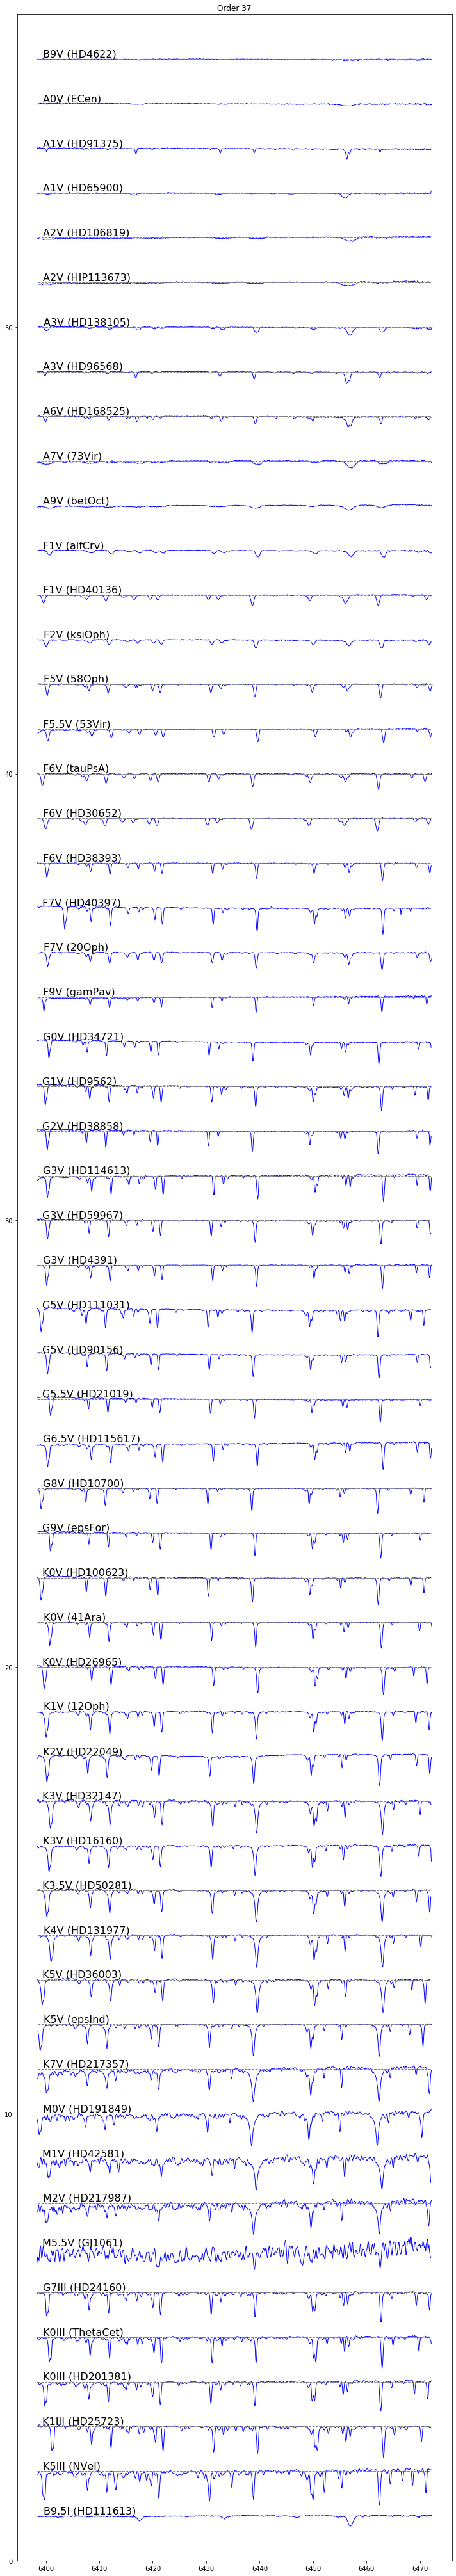

In [6]:
normlisSTD(37,stds,'y') #save all standards' normalized, nicely aligned order 1 in one handy plot

6


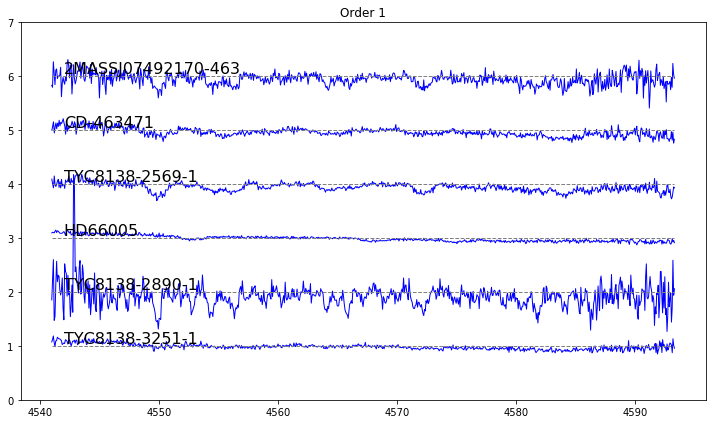

In [7]:
normlis(1,targs,'y') #save all targets' normalized order 1 in one handy plot

!!!!! Compare the standard and target spectra to guess the spectral types of the target stars. Make a tab-separated text document with the names and spectral types of each star and call it, for example, (cluster)_SpTGuess.dat. For example:

Notes column is optional but can be useful. A blank line at the end is required for smooth usage with opendat.

## Radial Velocity and Vsini Functions

This uses PyAstronomy's crosscorrRV, modified just slightly, and a Gaussian fit for measuring the center and width of the cross-correlation peak.

Measure radial velocity and vsini of one star compared to one standard: Use fitvsinilite.

Measure radial velocity and vsini of one star compared to all standards within 2 spectral classes: use fitvsini.

fitvsinilite has print and plot options for diagnosing issues. You can also plot cross-correlations if you toggle the pltcc variable at the top of the fitvsinilite function.

Often increasing skipedge can solve issues. You can specify skipedge for fitvsinilite. Fitvsini automatically increases skipedge when crosscorrRV fails. Total failure results in a skipped order; NaN values are assigned to that order.

In [8]:
def crosscorrRVn(w, f, tw, tf, rvmin, rvmax, drv, mode="normdop", skipedge=0, edgeTapering=None):
    """
        Cross-correlate a spectrum with a template.
        
        The algorithm implemented here works as follows: For
        each RV shift to be considered, the wavelength axis
        of the template is shifted, either linearly or using
        a proper Doppler shift depending on the `mode`. The
        shifted template is then linearly interpolated at
        the wavelength points of the observation
        (spectrum) to calculate the cross-correlation function.
        
        Parameters
        ----------
        w : array
                The wavelength axis of the observation.
        f : array
                The flux axis of the observation.
        tw : array
                The wavelength axis of the template.
        tf : array
                The flux axis of the template.
        rvmin : float
                Minimum radial velocity for which to calculate
                the cross-correlation function [km/s].
        rvmax : float
                Maximum radial velocity for which to calculate
                the cross-correlation function [km/s].
        drv : float
                The width of the radial-velocity steps to be applied
                in the calculation of the cross-correlation
                function [km/s].
        mode : string, {lin, doppler}, optional
                The mode determines how the wavelength axis will be
                modified to represent a RV shift. If "lin" is specified,
                a mean wavelength shift will be calculated based on the
                mean wavelength of the observation. The wavelength axis
                will then be shifted by that amount. If "doppler" is
                specified (the default), the wavelength axis will
                properly be Doppler-shifted.
        skipedge : int, optional
                If larger zero, the specified number of bins will be
                skipped from the begin and end of the observation. This
                may be useful if the template does not provide sufficient
                coverage of the observation.
        edgeTapering : float or tuple of two floats
                If not None, the method will "taper off" the edges of the
                observed spectrum by multiplying with a sine function. If a float number
                is specified, this will define the width (in wavelength units)
                to be used for tapering on both sides. If different tapering
                widths shall be used, a tuple with two (positive) numbers
                must be given, specifying the width to be used on the low- and
                high wavelength end. If a nonzero 'skipedge' is given, it
                will be applied first. Edge tapering can help to avoid
                edge effects (see, e.g., Gullberg and Lindegren 2002, A&A 390).
        
        Returns
        -------
        dRV : array
                The RV axis of the cross-correlation function. The radial
                velocity refer to a shift of the template, i.e., positive
                values indicate that the template has been red-shifted and
                negative numbers indicate a blue-shift of the template.
                The numbers are given in km/s.
        CC : array
                The cross-correlation function.
    """
    if not _ic.check["scipy"]:
        raise(PE.PyARequiredImport("This routine needs scipy (.interpolate.interp1d).", \
                                                             where="crosscorrRV", \
                                                             solution="Install scipy"))
    import scipy.interpolate as sci
    # Copy and cut wavelength and flux arrays
    w, f = w.copy(), f.copy()
    if skipedge > 0:
        w, f = w[skipedge:-skipedge], f[skipedge:-skipedge]
    
    if edgeTapering is not None:
        # Smooth the edges using a sine
        if isinstance(edgeTapering, float):
            edgeTapering = [edgeTapering, edgeTapering]
        if len(edgeTapering) != 2:
            raise(PE.PyAValError("'edgeTapering' must be a float or a list of two floats.", \
                                                     where="crosscorrRV"))
        if edgeTapering[0] < 0.0 or edgeTapering[1] < 0.0:
            raise(PE.PyAValError("'edgeTapering' must be (a) number(s) >= 0.0.", \
                                                     where="crosscorrRV"))
        # Carry out edge tapering (left edge)
        indi = np.where(w < w[0]+edgeTapering[0])[0]
        f[indi] *= np.sin((w[indi] - w[0])/edgeTapering[0]*np.pi/2.0)
        # Carry out edge tapering (right edge)
        indi = np.where(w > (w[-1]-edgeTapering[1]))[0]
        f[indi] *= np.sin((w[indi] - w[indi[0]])/edgeTapering[1]*np.pi/2.0 + np.pi/2.0)
    
    # Speed of light in km/s
    c = 299792.458
    # Check order of rvmin and rvmax
    if rvmax <= rvmin:
        raise(PE.PyAValError("rvmin needs to be smaller than rvmax.",
                                                 where="crosscorrRV", \
                                                 solution="Change the order of the parameters."))
    # Check whether template is large enough
    if mode == "lin":
        meanWl = np.mean(w)
        dwlmax = meanWl * (rvmax/c)
        dwlmin = meanWl * (rvmin/c)
        if (tw[0] + dwlmax) > w[0]:
            raise(PE.PyAValError("The minimum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
        if (tw[-1] + dwlmin) < w[-1]:
            raise(PE.PyAValError("The maximum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
    elif mode == "doppler" or mode == 'normdop':
        # Ensure that the template covers the entire observation for all shifts
        maxwl = tw[-1] * (1.0+rvmin/c)
        minwl = tw[0] * (1.0+rvmax/c)
        if minwl > w[0]:
            raise(PE.PyAValError("The minimum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
        if maxwl < w[-1]:
            raise(PE.PyAValError("The maximum wavelength is not covered by the template for all indicated RV shifts.", \
                                                     where="crosscorrRV", \
                                                     solution=["Provide a larger template", "Try to use skipedge"]))
    else:
        raise(PE.PyAValError("Unknown mode: " + str(mode), \
                                                 where="crosscorrRV", \
                                                 solution="See documentation for available modes."))
    # Calculate the cross correlation
    drvs = np.arange(rvmin, rvmax, drv)
    cc = np.zeros(len(drvs))
    for i, rv in enumerate(drvs):
        if mode == "lin":
            # Shift the template linearly
            fi = sci.interp1d(tw+meanWl*(rv/c), tf)
            cc[i] = np.sum(f * fi(w))
        elif mode == "doppler":
            # Apply the Doppler shift
            fi = sci.interp1d(tw*(1.0 + rv/c), tf)
            cc[i] = np.sum(f * fi(w))
        # Shifted template evaluated at location of spectrum
        elif mode == "normdop":
            # Apply the Doppler shift
            fi = sci.interp1d(tw*(1.0 + rv/c), tf)
        # Shifted template evaluated at location of spectrum
            cc[i] = 1./float(len(w)-skipedge)*np.sum((f-np.mean(f)) * (fi(w)-np.mean(fi(w))))/np.sqrt(np.var(f)*np.var(fi(w)))
    return drvs, cc

#barycentric correction
def bcv(head):
    #RA,Dec,expt,jd (jd of middle of exposure time)

    # Coordinates of CHIRON
    longitude = 360.-(70.+48./60.+24.44/3600.) #degrees 0 to 360
    latitude = -30.-10./60.-9.42/3600. #degrees
    altitude = 2207.3 #meters
    
    expt=head['EXPTIME'] #exposure time
    JD=Time(head['DATE-OBS']).jd+expt/2./60./24. #Julian day of middle of exposure, UT

    # Coordinates in degrees (J2000) for pyas1
    RA=[float(d)*15. for d in head['RA'].split(':')] #RA, degrees
    DEC=[float(d) for d in head['DEC'].split(':')] #Dec
    ra2000 = RA[0]+RA[1]/60.+RA[2]/3600. #RA
    dec2000 = DEC[0]/abs(DEC[0])*(abs(DEC[0])+DEC[1]/60.+DEC[2]/3600.) #Dec

    # Barycentric velocity correction
    cor = pyasl.helcorr(longitude, latitude, altitude,ra2000, dec2000, JD)[0]
    return cor

#retrieve rv,vsini,bcv from LogCruncher standards summary file
def refv(stdname):
    name,vsini,vsinierr,rv,rverr,barycorr=opendat(csdir,'CHIRON_standards_grand_summary.dat',['#name','vsini', 'vsinierr', 'rv', 'rverr','barycorr'])
    i=name.index(stdname)
    return vsini[i],vsinierr[i],rv[i],rverr[i],float(barycorr[i])

def refspt(stdname):
    name,spt=opendat(csdir,'CHIRON_standards_grand_summary.dat',['#name','spt'])
    i=name.index(stdname)
    return spt[i]

def gaussian(x, amp, cen, wid): # Gaussian model
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return ((1 * amp) / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2)) 
gmodel = Model(gaussian)

#Target versions of error-handling:
#    rvxstd=np.sqrt(np.nanstd(rvx)**2.+rv0err**2.) # for target, add std rverr in quadrature
#    vsinixstd=np.sqrt(np.nanstd(vsinix)**2.+vsini0err**2.)  # for target, add std vsinierr in quadrature

def fitvsinilite(name,stdname,rvcent0=0,vsinistart0=0,skipedge0=0,prin='n',plotyn='n'): #returns the essentials.
    #toggle to check crosscorr:
    pltcc='n' #'y' or 'n'
    
    #This one set for targets; includes standards' uncert
    #target:
    dat,head=opfits(name) #.fits data
    bc=bcv(head) #barycentric correction
    ws,fs,svs=normalize_rv(dat,head) #wavelength, normalized flux, and sigma_v of each order
    dw=1.6 #fiber
    
    #standard:
    dat0,head0=opfits(stdname) #.fits data
    vsini0,vsini0err,rv0,rv0err,bc0=refv(stdname) #barycentric correction
    ws0,fs0,svs0=normalize_rv(dat0,head0) #wavelength, normalized flux, and sigma_v of each order
    weights0=(1./np.array(svs0)**2.)/sum(1./np.array(svs0)**2.) #based on standard's svs
    stdspt=refspt(stdname)
    
    rvcent00=rvcent0-rv0+bc0-bc
    
    rvs,vsinis=[],[]
    
    #pick vwindow for rv and vsini, based on orders 1,11,22
    vwins=[]
    if pltcc=='y':
        ccs=[]
    for i in [1,11,22]:
        o=i
        w,f=np.array(ws[i]),np.array(fs[i])-1. #pyasl code wants spectra normalized to 0! Weird.
        w0,f0=np.array(ws0[i]),np.array(fs0[i])-1. #""
        
        rv, cc = crosscorrRVn(w, f, w0, f0, rvcent00-100., rvcent00+100.,dw,skipedge=50+int(0.5*vsinistart0)+skipedge0,edgeTapering=10.+0.25*vsinistart0) #The less skipedge, the better. edgeTapering seems happy near 10.??
        maxind = np.argmax(cc)
        if pltcc=='y':
            ccs.append(cc)
        try:
            min1=np.max([a for a in argrelextrema(cc,np.less)[0] if a<maxind])
            min2=np.min([a for a in argrelextrema(cc,np.less)[0] if a>maxind])
            vwin=np.max([(min2-min1)/4.,4.]) #4 is the minimum. /4 because otherwise too broad or gaussian fits poorly
            vwins.append(vwin)
        except ValueError:
            print('order',i,'could not find peak or neighboring minima.')
            print([a for a in argrelextrema(cc,np.less)[0] if a<maxind])
            print([a for a in argrelextrema(cc,np.less)[0] if a>maxind])
    
    vwindow=np.nanmax([np.median(vwins),4.])
    rvcent=rv[maxind]
    vsinistart=np.max([vwindow-29.,vsinistart0])
    print('vsini window',vwindow,', vsini start',vsinistart,', rv cent',rvcent)
    
    if pltcc=='y':
        for i in range(3):
            plt.figure(figsize=(5,5))
            plt.title('cross-corr of order '+str([1,11,22][i]))
            plt.plot(ccs[i])
            plt.ylabel('norm\'d cc')
            plt.xlabel('index')
            plt.plot([np.argmax(ccs[i])-int(vwindow+1.0*vsinistart),np.argmax(ccs[i])+int(vwindow+1.0*vsinistart)],[ccs[i][np.argmax(ccs[i])]*0.5,ccs[i][np.argmax(ccs[i])]*0.5])
    
    #find good approx. vsini and refine rvdiff
    rvdiffs,vsinibroads=[],[]
    V = np.linspace(0+vsinistart,60+vsinistart,10) # collection of vsini. Ultimately works for up to ~60+30 = 90 km/s of broadening.
    for i in [1,11,22]: #[0,]:
        o=i
        w,f=np.array(ws[i]),np.array(fs[i])-1. #pyasl code wants spectra normalized to 0! Weird.
        w0,f0=np.array(ws0[i]),np.array(fs0[i])-1. #""
        rv, cc = crosscorrRVn(w, f, w0, f0, rvcent-100., rvcent+100.,dw,skipedge=50+int(0.5*vsinistart)+skipedge0,edgeTapering=10.+0.25*vsinistart) #The less skipedge, the better. edgeTapering seems happy near 10.??
        maxind = np.argmax(cc)
        #vsini
        xnew = np.linspace(w0[0],w0[-1],len(w0)) # uniform wavelength spacing
        ynew = np.interp(xnew,w0,f0) #standard spectrum interpolated to uniform wavelength spacing
        hs=[]
        for v in V: # empirical vsini relation from broadened template
            if v==0:
                v=0.01
            bflux = pyasl.rotBroad(xnew, ynew, 0.6, v) # flux of broadened spectrum
            rV, cC = crosscorrRVn(xnew, bflux, xnew, ynew,-1*int(vwindow+1.0*vsinistart),int(vwindow+1.0*vsinistart),dw,skipedge=25+int(0.5*vsinistart),edgeTapering=10.+0.25*vsinistart) #need to increase for faster rotation? Keep checking.
            result = gmodel.fit(cC, x=rV, amp=1., cen=0., wid=1.)
            h = result.best_values #gauss width of std with rot'l broadening of v km/s
            hs.append(h['wid'])
        width = hs #np.genfromtxt(file1) # use empirical relation to get RV and vsini
        rvmin = rv[maxind] - (vwindow+1.0*vsinistart)
        rvmax = rv[maxind] + (vwindow+1.0*vsinistart)
        rv2, cc2 = crosscorrRVn(w, f, w0, f0, rvmin, rvmax,dw,skipedge=25+int(0.5*vsinistart)+skipedge0,edgeTapering=10.+0.25*vsinistart) 
        maxind = np.argmax(cc2)
        
        if pltcc=='y':
                plt.figure(figsize=(5,5))
                plt.title('cross-corr of order '+str(o))
                plt.plot(rv2,cc2)
                plt.ylabel('norm\'d cc')
                plt.xlabel('rv')
                plt.plot([rvmin,rvmax],[cc2[np.argmax(cc2)]*0.5,cc2[np.argmax(cc2)]*0.5])
        
        try:
            result = gmodel.fit(cc2, x=rv2, amp=cc2[maxind], cen=rv2[maxind], wid=1.) #gauss width of actual target spectrum
            h = result.best_values
            RVdiff = h['cen'] #really the rv diff between standard and target.
            vsini = np.interp(h['wid'],width,V) #just the broadening
            #if vsini is considerably smaller than vsini_std, discard the measurement:
            #if vsini==vsini0:
            #    vsini=float('nan') #but this doesn't seem to work with my V intervals.
            #rv shouldn't change from day to day, month to month, as earth moves. So rv must be relative to point of rest.
            #bcv is motion of earth towards a star. So star's motion away from rest point is actually obs'd motion of star + calc'd motion of earth toward star.
            #u: uncorrected, c: corrected. 0:standard
            #rvc= rv0c + rvcdiff = rv0c + (rvc - rv0c) = rv0c + ((rvu + bc) - (rv0u + bc0)) = rv0c + (rvu - rv0u) + bc - bc0
            #RV_true= rv0 + RVdiff + bc - bc0
            rvdiffs.append(RVdiff)
            vsinibroads.append(vsini)
        except ValueError:
            print('Failed to fit Gaussian to order '+str(o)+'.')
            rvdiffs.append(np.float('nan'))
            vsinibroads.append(np.float('nan'))
    #Remove outliers based on median and std of middle quartile
    midrv=np.median(rvdiffs)
    midstd=np.std(np.array([d for d in rvdiffs if d>np.percentile(rvdiffs,25) and d<np.percentile(rvdiffs,75)]))
    stdfac=3.
    rvres=10. #km/s, arbitrary at the moment
    rmin=midrv-stdfac*midstd if stdfac*midstd>rvres else midrv-rvres
    rmax=midrv+stdfac*midstd if stdfac*midstd>rvres else midrv+rvres
    rvx=np.array([d for d in rvdiffs if d>rmin and d<rmax])
    #bados=[os[i] for i in range(len(rvs)) if rvs[i]<=rmin or rvs[i]>=rmax]
    #weighted rv
    weights0=1./np.array(svs0)**2.
    weights0x=np.array([weights0[i] for i in range(len(rvdiffs)) if rvdiffs[i]>rmin and rvdiffs[i]<rmax])
    #normalize the weights
    weights0xn=weights0x/sum(weights0x)
    #rv
    rvxw=sum(rvx*weights0xn)
    #vsini
    vsinix=np.array([vsinibroads[i] for i in range(len(rvdiffs)) if rvdiffs[i]>rmin and rvdiffs[i]<rmax])
    #normalize the weights
    weights0xx=[weights0x[i] if np.isnan(vsinix[i])==False else float('nan') for i in range(len(weights0x))] #keep if vsini any good
    weights0xxn=weights0xx/np.nansum(weights0xx)
    vsinixw=np.nansum(vsinix*weights0xxn)
    
    #do full analysis with very tailored rvcent,vsinistart
    rvcent=rvxw
    vsinistart=np.max((vsinixw-10,0))
    print('new vsini start',vsinistart,', new rv cent',rvcent)
    V = np.linspace(0+vsinistart,20+vsinistart,10) # collection of vsini. Winner: 20/10.
    for i in range(len(os)): #[0,]:
        o=os[i]
        w,f=np.array(ws[i]),np.array(fs[i])-1. #pyasl code wants spectra normalized to 0! Weird.
        w0,f0=np.array(ws0[i]),np.array(fs0[i])-1. #""
        rv, cc = crosscorrRVn(w, f, w0, f0, rvcent-10.-int(vsinistart/2.), rvcent+10.+int(vsinistart/2.),dw,skipedge=50+int(0.5*vsinistart)+skipedge0,edgeTapering=10.+0.25*vsinistart) #The less skipedge, the better. edgeTapering seems happy near 10.??
        maxind = np.argmax(cc)
        #vsini
        xnew = np.linspace(w0[0],w0[-1],len(w0)) # uniform wavelength spacing. Winner: original resolution.
        ynew = np.interp(xnew,w0,f0)
        hs=[]
        for v in V: # empirical vsini relation from broadened template
            if v==0:
                v=0.01
            bflux = pyasl.rotBroad(xnew, ynew, 0.6, v) # flux of broadened spectrum 
            rV, cC = crosscorrRVn(xnew, bflux, xnew, ynew,-1*int(vwindow+1.0*vsinistart),int(vwindow+1.0*vsinistart),dw,skipedge=25+int(0.5*vsinistart),edgeTapering=10.+0.25*vsinistart) #need to increase for faster rotation? Keep checking.
            result = gmodel.fit(cC, x=rV, amp=1., cen=0., wid=1.)
            h = result.best_values
            hs.append(h['wid'])
        ###width = hs #np.genfromtxt(file1) # use empirical relation to get RV and vsini
        width=[hs[i] for i in range(len(hs)-1) if hs[i+1]-hs[i]>0.01]+[hs[-1],] #delete vertical front if present
        V2=[V[i] for i in range(len(hs)-1) if hs[i+1]-hs[i]>0.01]+[V[-1],] #match width
        rvmin = rv[maxind] - (vwindow+1.0*vsinistart)
        rvmax = rv[maxind] + (vwindow+1.0*vsinistart)
        rv2, cc2 = crosscorrRVn(w, f, w0, f0, rvmin, rvmax,dw,skipedge=25+int(0.5*vsinistart)+skipedge0,edgeTapering=10.+0.25*vsinistart) 
        maxind = np.argmax(cc2)
        try:
            result = gmodel.fit(cc2, x=rv2, amp=cc2[maxind], cen=rv2[maxind], wid=1.) 
            h = result.best_values
            RVdiff = h['cen'] #really the rv diff between standard and target.
            RV_true= rv0 + RVdiff + bc - bc0
            rvs.append(RV_true)
            ###vsini = np.interp(h['wid'],width,V+vsini0) #map to vsini unbroadened = vsini_std
            ###new vsini###
            if h['wid']>np.min(width) and h['wid']<np.max(width):
                vsinibroad = np.interp(h['wid'],width,V2) #map to vsini unbroadened = vsini_std. #based on the relation of gauss widths to v broadenings + vsini_std generated earlier, the actual width of the target should correspond to THIS vsini.
                vsinis.append(vsini)
                vsini=vrotcombo(vsini0,vsinibroad)
                fitpass='y'
                if prin=='y':
                    print(vsini)
                x,y,x_new,y_new,xnew,ynew=float('nan'),float('nan'),float('nan'),float('nan'),float('nan'),float('nan')
            #new vsini from fitted func, only if a little off the chart
            elif h['wid']>np.min(width)-2. and h['wid']<np.max(width)+2.:
                X,Y=width,V2 #+vsini0
                points=np.array([(X[i],Y[i]) for i in range(len(X))])
                # get x and y vectors
                x = points[:,0]
                y = points[:,1]
                # calculate polynomial
                z = np.polyfit(x, y, 2)
                f = np.poly1d(z)
                # calculate new x's and y's
                x_new = np.linspace(np.min(width)-2, np.max(width)+2, len(width))
                y_new = f(x_new)
                xnew=h['wid']
                ynew=f(xnew)
                ###
                vsinibroad=ynew
                vsini=vrotcombo(vsini0,vsinibroad)
                vsinis.append(vsini)
                fitpass='y'
                if prin=='y':
                    print(vsini)
            else:
                vsinis.append(float('nan'))
                if prin=='y':
                    print(vsini, "Skipping order",o,'for vsini.')
                x,y,x_new,y_new,xnew,ynew=float('nan'),float('nan'),float('nan'),float('nan'),float('nan'),float('nan')
                fitpass='n'
        
        except ValueError:
            print('Failed to fit Gaussian to order '+str(o)+'.')
            rvs.append(np.float('nan'))
            vsinis.append(np.float('nan'))
        
        if plotyn=='y': #o==24 and 
            plt.figure(figsize=(5,5))
            plt.plot(width,V2,marker='o')
            plt.scatter(h['wid'],vsinibroad,color='red')
            plt.ylabel('vsini broadening')
            plt.xlabel('width')
            plt.title('From '+stdname+', vsini_std = '+str(round(vsini0,2))+' km/s')
            plt.plot(x,y,'o', x_new, y_new,color='green',ls='--',lw=1.5)
            plt.scatter(xnew,ynew,color='red')
            if fitpass=='n':
                plt.scatter(h['wid'],vsini,marker='x',lw=1.2,color='black',s=90)
    
    #Remove outliers based on median and std of middle quartile
    midrv=np.nanmedian(rvs)
    midstd=np.nanstd(np.array([d for d in rvs if d>np.percentile(rvs,25) and d<np.percentile(rvs,75)]))
    stdfac=3.
    rvres=10. #km/s, arbitrary at the moment
    rmin=midrv-stdfac*midstd if stdfac*midstd>rvres else midrv-rvres
    rmax=midrv+stdfac*midstd if stdfac*midstd>rvres else midrv+rvres
    rvx=np.array([d for d in rvs if d>rmin and d<rmax])
    bados=[os[i] for i in range(len(rvs)) if rvs[i]<=rmin or rvs[i]>=rmax]
    #weighted rv
    weights0=1./np.array(svs0)**2.
    weights0x=np.array([weights0[i] for i in range(len(rvs)) if rvs[i]>rmin and rvs[i]<rmax])
    #normalize the weights
    weights0xn=weights0x/sum(weights0x)
    #rv
    rvxw=np.nansum(rvx*weights0xn)
    rvxstd=np.sqrt(np.nanstd(rvx)**2.+rv0err**2.) # for target, add std rverr in quadrature
    #vsini
    vsinix=np.array([vsinis[i] for i in range(len(rvs)) if rvs[i]>rmin and rvs[i]<rmax])
    #normalize the weights
    weights0xx=[weights0x[i] if np.isnan(vsinix[i])==False else float('nan') for i in range(len(weights0x))] #keep if vsini any good
    weights0xxn=weights0xx/np.nansum(weights0xx)
    vsinixw=np.nansum(vsinix*weights0xxn)
    if np.isnan(vsini0err)==True:
        vsini0err=1. #arbitrary
        print('Unknown vsini_std_err set to 1. km/s.')
    vsinixstd=np.sqrt(np.nanstd(vsinix)**2.+vsini0err**2.)  # for target, add std vsinierr in quadrature
    if vsinixw==0.0: #if no width-to-vsini plots worked, then probably vsini_target < vsini_std, and this result should be thrown out.
        vsinixw2=float('nan')
        vsinixstd2=float('nan')
        vsiniflag='(NULL AND VOID, vsini_std > vsini_target)'
    elif vsinixstd<0.1: #arbitrary
        vsinixw2=vsinixw
        vsinixstd2=0.1
        vsiniflag='(vsinierr adjusted to 0.1 km/s)'
    else:
        vsinixw2=vsinixw
        vsinixstd2=vsinixstd
        vsiniflag=''
    vsinilen=len([a for a in vsinix if np.isnan(a)==False])
    print('Weighted rv of',name,' (',stdspt,') :',rvxw,'+-',rvxstd,'km/s')
    print('Weighted vsini of',name,' (',stdspt,') :',vsinixw,'+-',vsinixstd,'km/s',vsiniflag)
    
    return stdname,stdspt,rvxw,rvxstd,vsinixw2,vsinixstd2,bados,vsinilen,skipedge0

def fitvsini(name,spt,rvcent0=0,vsinistart0=0,skipedge0=0,prin='n',plotyn='n'): #target name, spectral type (including lum. class). Need standards all loaded up.
    svalue=sval(spt)
    #take all standards within 2 sval of svalue.
    standards=[stds[i] for i in range(len(stds)) if abs(ssval[i]-svalue)<=2]
    print(standards)
    num=len(standards)
    stdnames,stdspts,rvs,rverrs,vsinis,vsinierrs,bados,vsinilen,skipage=['',]*num,['',]*num,['',]*num,['',]*num,['',]*num,['',]*num,['',]*num,['',]*num,['',]*num
    skipedgestd=0
    for i in range(num):
        done='n'
        print(name,standards[i])
        while done=='n':
            try:
                stdnames[i],stdspts[i],rvs[i],rverrs[i],vsinis[i],vsinierrs[i],bados[i],vsinilen[i],skipage[i]=fitvsinilite(name,standards[i],rvcent0,vsinistart0,skipedgestd,prin=prin,plotyn=plotyn) #'target','standard'
                done='y'
            except PE.PyAValError:
                print('Fitvsini failed, increasing skipedge...')
                skipedgestd+=5
    flags=[stdnames[i] if abs(rvs[i]-np.median(rvs))>np.std(rvs) and abs(rvs[i]-np.median(rvs))>0.3 else '0' for i in range(len(rvs))]
    rv=erm(rvs,rverrs)[0]
    rverr=np.max([np.std(rvs),erm(rvs,rverrs)[1]]) #spread of rvs is preferred uncert, while erm uncert is lower limit
    vsini=erm(vsinis,vsinierrs)[0]
    vsinierr=np.max([np.std(vsinis),erm(vsinis,vsinierrs)[1]]) # "" for vsinis
    
    #favor vsini measurements that utilize more orders:
    #combined by # of orders utilized:
    #vsini=np.nansum(np.array(vsinis)*np.array(vsinilen)/np.nansum(vsinilen))
    #vsinierr=np.sqrt(np.nansum((np.array(vsinierrs)*np.array(vsinilen)/np.nansum(vsinilen)**2.)))
    
    bestspt=stdspts[np.argmin(rverrs)]
    return name,rv,rverr,vsini,vsinierr,bestspt,stdnames,stdspts,rvs,rverrs,vsinis,vsinierrs,bados,vsinilen,flags

def vrotcombo(vstd,vbroad): #"adds" vsinis to get total vsini
    x=vstd
    y=vbroad
    r=np.sqrt(x**2.+y**2.)
    theta=np.arctan(y/x)
    v0=0.044*r #deflection from circle
    if theta<=np.pi/4.:
        vtot=r+4.*v0/np.pi*theta
    if theta>np.pi/4.:
        vtot=r-4.*v0/np.pi*theta+2.*v0
    return vtot

## Measure Radial Velocities and Vsinis

Here's where the measurements happen. This code is currently set to only measure radial velocities of stars with spectral type A5 and later. F, G, K work best.

In [9]:
print(fitvsinilite('2MASSJ07492170-463','58Oph'))

['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 'exptime', 'jd', 'barycorr']
['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 'exptime', 'jd', 'barycorr']
vsini window 10.0 , vsini start 0.0 , rv cent 16.11676696588509
new vsini start 29.48736760560763 , new rv cent 13.813816041699095
Weighted rv of 2MASSJ07492170-463  ( F5V ) : 22.129735855612427 +- 1.5426578451821724 km/s
Weighted vsini of 2MASSJ07492170-463  ( F5V ) : 43.901867926301854 +- 3.533945153523897 km/s 
('58Oph', 'F5V', 22.129735855612427, 1.5426578451821724, 43.901867926301854, 3.533945153523897, [], 30, 0)


In [10]:
sptnames,spts=opendat(ctdir,cluster+'_SpTGuess.dat',['#name', 'SpTGuess']) #!!!!!
tspts=[spts[sptnames.index(n.replace('_2',''))] for n in targs]
print(len(targs))
whichnames,whichstds,whichstdspts,trvs,trverrs,tvsinis,tvsinierrs,tbestspts,stdflags,whichbados,vsinilens=[],[],[],[],[],[],[],[],[],[],[]

['#name', 'SpTGuess', 'notes']
6


In [11]:
#Measure all.
for tname in targs:
    tSpT=tspts[targs.index(tname)]
    print(targs.index(tname)+1,'of',len(targs))
    if sval(tSpT)<=46:    #for SpT A5 and later
        print(tname,tSpT)
        whichname,rv,rverr,vsini,vsinierr,bestspt,stdnames,stdspts,rvs,rverrs,vsinis,vsinierrs,bados,vsinilen,flags=fitvsini(tname,tSpT)
        whichnames.append(whichname)
        whichstds.append(stdnames)
        whichstdspts.append(stdspts)
        trvs.append(rvs)
        trverrs.append(rverrs)
        tvsinis.append(vsinis)
        tvsinierrs.append(vsinierrs)
        tbestspts.append(bestspt)
        stdflags.append(flags)
        whichbados.append(bados)
        vsinilens.append(vsinilen)

1 of 6
2MASSJ07492170-463 F5.5V
['58Oph', '53Vir', 'tauPsA', 'HD30652', 'HD38393', 'HD40397', '20Oph']
2MASSJ07492170-463 58Oph
['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 'exptime', 'jd', 'barycorr']
['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 'exptime', 'jd', 'barycorr']
vsini window 10.0 , vsini start 0.0 , rv cent 16.11676696588509
new vsini start 29.48736760560763 , new rv cent 13.813816041699095
Weighted rv of 2MASSJ07492170-463  ( F5V ) : 22.129735855612427 +- 1.5426578451821724 km/s
Weighted vsini of 2MASSJ07492170-463  ( F5V ) : 43.901867926301854 +- 3.533945153523897 km/s 
2MASSJ07492170-463 53Vir
['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 'exptime', 'jd', 'barycorr']
['#name', 'ra', 'dec', 'V', 'spt', 'Teff', 'Tefferr', 'rv', 'rverr', 'rvref', 'vsini', 'vsinierr', 'vsiniref', 

KeyboardInterrupt: 

In [12]:
#Write results.
fitvsinifile=cluster+'_fitvsini.dat' # !!!!!

whichnames2=[[whichnames[i]]*len(whichstds[i]) for i in range(len(whichnames))]
tbestspts2=[[tbestspts[i]]*len(whichstds[i]) for i in range(len(whichnames))]

dat=[sum(whichnames2,[]),sum(whichstds,[]),sum(whichstdspts,[]),sum(list(trvs),[]),sum(list(trverrs),[]),sum(list(tvsinis),[]),sum(list(tvsinierrs),[]),sum(tbestspts2,[]),sum(stdflags,[])]
pdat=[[str(d[i]) for d in dat] for i in range(len(sum(whichnames2,[])))]
lab=['#name','std','stdspt','rv','rverr','vsini','vsinierr','bestspt','flag'] #flag is potentially bad standard
if exists(ctdir+fitvsinifile):
    rewri=input("Rewrite targets' fitvsini results? 'y'/'n'\n")
    if rewri=='y':
        f=open(ctdir+fitvsinifile,'w')
        print('\t'.join(lab),file=f)
        for d in pdat:
            print('\t'.join(d),file=f)
        f.close()
        print('File rewritten.')
else:
    f=open(ctdir+fitvsinifile,'w')
    print('\t'.join(lab),file=f)
    for d in pdat:
        print('\t'.join(d),file=f)
    f.close()
    print('File written.')

File written.


In [13]:
name,std,stdspt,rv,rverr,vsini,vsinierr,spt,flag=opendat(ctdir,cluster+'_fitvsini.dat',['#name', 'std','stdspt', 'rv', 'rverr', 'vsini', 'vsinierr', 'bestspt', 'flag'])

def flagrep(): #with data from stdTest all loaded up
    flagged=[flag[i] for i in range(len(flag)) if flag[i] not in flag[:i] and flag[i]!='0' and flag[i]!=0] #all unique flagged items
    if len(flagged)==0:
        print('No flags found. The standards are awesome.')
    else:
        maxlen=np.max([len(a) for a in flagged])
        flagcount=[flag.count(a) for a in flagged if a!='0']
        usecount =[std.count(a)  for a in flagged if a!='0']
        #rep=[a+':'+' '*(maxlen-len(a))+'\tUSED: '+str(std.count(a))+'\tFLAGGED: '+str(flag.count(a)) for a in flagged if a!='0']
        for i in range(len(flagcount)):
            if flagcount[i]==usecount[i]:
                redflag=' !!!'
            elif flagcount[i]==usecount[i]-1 or flagcount[i]>=usecount[i]*1/2.:
                redflag=' !'
            else:
                redflag=''
            print(flagged[i]+':'+' '*(maxlen-len(flagged[i]))+'\tUSED: '+str(usecount[i])+' '*(maxlen-len(str(usecount[i])))+'\tFLAGGED: '+str(flagcount[i])+' '*(maxlen-len(str(flagcount[i])))+redflag)

def rvrep(Name,form='long'): #form long or short or noprint or data
    STDs=[std[i] for i in range(len(name)) if name[i]==Name]
    RVs=[rv[i] for i in range(len(name)) if name[i]==Name]
    RVerrs=[rverr[i] for i in range(len(name)) if name[i]==Name]
    VSINIs=[vsini[i] for i in range(len(name)) if name[i]==Name]
    VSINIerrs=[vsinierr[i] for i in range(len(name)) if name[i]==Name]

    if form=='long':
        print(Name+':')
        for i in range(len(STDs)):
            print(round(RVs[i],2),'\t+/-',round(RVerrs[i],2),'\t',STDs[i])
        print('Final rv: ',round(erm(RVs,RVerrs)[0],2),'+-',round(erm(RVs,RVerrs)[1],2))
    elif form=='short':
        print(Name+':',' '*(19-len(Name)),round(erm(RVs,RVerrs)[0],2),'+-',round(erm(RVs,RVerrs)[1],2))
    elif form=='no print' or form=='data':
        #well, no print!
        a='Cass'
    else:
        print("Choose form='long' or 'short' or 'noprint' or 'data'. Default: long.")
    if form=='long' or form=='short':
        return round(erm(RVs,RVerrs)[0],2),'+-',round(erm(RVs,RVerrs)[1],2)
    if form=='data':
        Rv,Rverr=erm(RVs,RVerrs)
        Vsini,Vsinierr=erm(VSINIs,VSINIerrs)
        theSTD=STDs[np.argmin(RVerrs)]
        Spt=stdspt[std.index(theSTD)]
        numstd=len(STDs)
        return Name,Rv,Rverr,Vsini,Vsinierr,Spt,theSTD,numstd
    
def rvrep_std(Name):
    STDs=[std[i] for i in range(len(name)) if name[i]==Name and std[i]!=Name]
    RVs=[rv[i] for i in range(len(name)) if name[i]==Name and std[i]!=Name]
    RVerrs=[rverr[i] for i in range(len(name)) if name[i]==Name and std[i]!=Name]
    TheRV=[rv[i] for i in range(len(name)) if name[i]==Name and std[i]!=Name]

    print(Name+':')
    for i in range(len(STDs)):
        print(round(RVs[i],2),'\t+/-',round(RVerrs[i],2),'\t',STDs[i])
    print('ref rv: ',round([rv[i] for i in range(len(name)) if name[i]==Name and std[i]==Name][0],3),'+-',round([rverr[i] for i in range(len(name)) if name[i]==Name and std[i]==Name][0],3))
    print('Measured rv: ',round(erm(RVs,RVerrs)[0],3),'+-',round(erm(RVs,RVerrs)[1],3))

def stdrep(STD):
    Names=[name[i] for i in range(len(name)) if std[i]==STD]
    for Name in Names:
        rvrep(Name)
        print()
        
def nodup(lis): #extract only unique elements of list
    return [lis[i] for i in range(len(lis)) if lis[i] not in lis[:i]]

['#name', 'std', 'stdspt', 'rv', 'rverr', 'vsini', 'vsinierr', 'bestspt', 'flag']


In [14]:
#parse the rv data with error-weighted mean
namervs,rvs,rverrs,vsinis,vsinierrs,spts,stds,numstds=[],[],[],[],[],[],[],[]

print(cluster+' rv:')
for n in nodup(name):
    Name1,rv1,rverr1,vsini1,vsinierr1,spt1,theSTD1,numstd1=rvrep(n,form='data')
    namervs.append(Name1)
    rvs.append(rv1)
    rverrs.append(rverr1)
    vsinis.append(vsini1)
    vsinierrs.append(vsinierr1)
    spts.append(spt1)
    stds.append(theSTD1)
    numstds.append(numstd1)
    print(Name1,' '*(np.max([len(na) for na in namervs])-len(Name1)),'\t',round(rv1,2),'+-',round(rverr1,2))

print('\n',cluster+' MEDIAN +- STD:',round(np.mean(rvs),2),'+-',round(np.std(rvs),2))

targs rv:
2MASSJ07492170-463  	 22.07 +- 0.63
CD-463471           	 28.3 +- 7.76

 targs MEDIAN +- STD: 25.19 +- 3.12


In [15]:
#Save results.
lab=['#name','rv','rverr','vsini','vsinierr','numstd','bestspt','beststd'] #bestspt from lowest-rverr std
dat=[namervs,rvs,rverrs,vsinis,vsinierrs,numstds,spts,stds]
datp=[[str(a) for a in d] for d in dat]

print(lab)
f=open(ctdir+cluster+'_rvs.dat','w')
print('\t'.join(lab),file=f)
for d in datp:
    print('\t'.join(d),file=f)
f.close()

['#name', 'rv', 'rverr', 'vsini', 'vsinierr', 'numstd', 'bestspt', 'beststd']
